### Get the dataset
The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

In [1]:
!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

In [2]:
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()

In [3]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

print_config()

MONAI version: 0.9.dev2223
Numpy version: 1.22.4
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0428f5a29f1fdc577f2c558490266d9db00583e3
MONAI __file__: /home/batselem/anaconda3/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.9.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.4
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies




## Read image filenames from the dataset folders
First of all, check the dataset files and show some statistics.
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
which should be used as the labels to train our classification model.

In [5]:
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


# Visualise some randomly picked examples from the dataset

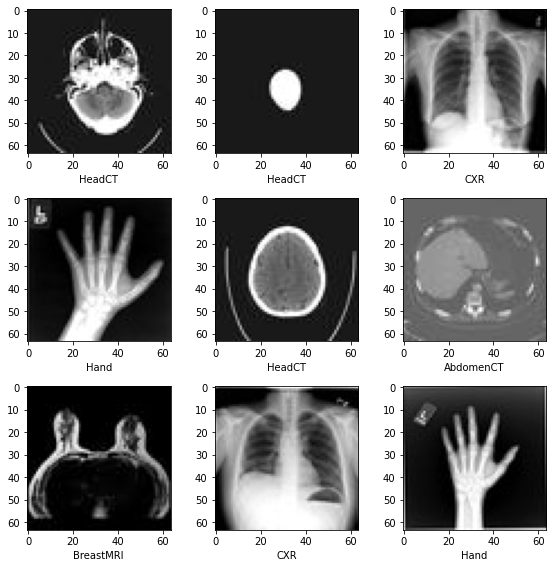

In [6]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists
Randomly select 10% of the dataset as validation and 10% as test.

In [8]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 46994 Validation count = 5998 Test count = 5962


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [9]:
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.


In [10]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=2)

## Define network and optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
And as this is just a get start tutorial, let's just train 4 epochs.
If train 10 epochs, the model can achieve 100% accuracy on test dataset.
3. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
4. Use Adam optimizer.

In [11]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 4
val_interval = 1

## Model training
Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.
Will save the model weights to file if got best validation accuracy.

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/156, train_loss: 1.8221
2/156, train_loss: 1.7866
3/156, train_loss: 1.7601
4/156, train_loss: 1.7469
5/156, train_loss: 1.7346
6/156, train_loss: 1.6773
7/156, train_loss: 1.6900
8/156, train_loss: 1.6253
9/156, train_loss: 1.6404
10/156, train_loss: 1.5867
11/156, train_loss: 1.6015
12/156, train_loss: 1.5482
13/156, train_loss: 1.5568
14/156, train_loss: 1.5225
15/156, train_loss: 1.5085
16/156, train_loss: 1.4665
17/156, train_loss: 1.4677
18/156, train_loss: 1.4442
19/156, train_loss: 1.4302
20/156, train_loss: 1.3599
21/156, train_loss: 1.4517
22/156, train_loss: 1.3565
23/156, train_loss: 1.3498
24/156, train_loss: 1.3302
25/156, train_loss: 1.3642
26/156, train_loss: 1.3413
27/156, train_loss: 1.3322
28/156, train_loss: 1.2502
29/156, train_loss: 1.2113
30/156, train_loss: 1.2355
31/156, train_loss: 1.2149
32/156, train_loss: 1.1769
33/156, train_loss: 1.2186
34/156, train_loss: 1.1458
35/156, train_loss: 1.1413
36/156, train_loss: 1.1850
37/156, train_lo

139/156, train_loss: 0.1349
140/156, train_loss: 0.1251
141/156, train_loss: 0.1352
142/156, train_loss: 0.1361
143/156, train_loss: 0.1468
144/156, train_loss: 0.1250
145/156, train_loss: 0.1082
146/156, train_loss: 0.1145
147/156, train_loss: 0.1357
148/156, train_loss: 0.1168
149/156, train_loss: 0.1015
150/156, train_loss: 0.1250
151/156, train_loss: 0.1049
152/156, train_loss: 0.1063
153/156, train_loss: 0.1368
154/156, train_loss: 0.1116
155/156, train_loss: 0.1195
156/156, train_loss: 0.1055
157/156, train_loss: 0.1059
epoch 2 average loss: 0.1946
saved new best metric model
current epoch: 2 current AUC: 0.9996 current accuracy: 0.9833 best AUC: 0.9833 at epoch: 2
----------
epoch 3/4
1/156, train_loss: 0.1165
2/156, train_loss: 0.1239
3/156, train_loss: 0.1013
4/156, train_loss: 0.0922
5/156, train_loss: 0.1146
6/156, train_loss: 0.1165
7/156, train_loss: 0.1440
8/156, train_loss: 0.1339
9/156, train_loss: 0.1249
10/156, train_loss: 0.1195
11/156, train_loss: 0.1450
12/156, tra

115/156, train_loss: 0.0368
116/156, train_loss: 0.0524
117/156, train_loss: 0.0454
118/156, train_loss: 0.0726
119/156, train_loss: 0.0416
120/156, train_loss: 0.0421
121/156, train_loss: 0.0612
122/156, train_loss: 0.0391
123/156, train_loss: 0.0587
124/156, train_loss: 0.0515
125/156, train_loss: 0.0603
126/156, train_loss: 0.0470
127/156, train_loss: 0.0509
128/156, train_loss: 0.0530
129/156, train_loss: 0.0415
130/156, train_loss: 0.0472
131/156, train_loss: 0.0428
132/156, train_loss: 0.0400
133/156, train_loss: 0.0446
134/156, train_loss: 0.0556
135/156, train_loss: 0.0438
136/156, train_loss: 0.0371
137/156, train_loss: 0.0455
138/156, train_loss: 0.0385
139/156, train_loss: 0.0591
140/156, train_loss: 0.0392
141/156, train_loss: 0.0412
142/156, train_loss: 0.0488
143/156, train_loss: 0.0392
144/156, train_loss: 0.0546
145/156, train_loss: 0.0444
146/156, train_loss: 0.0520
147/156, train_loss: 0.0510
148/156, train_loss: 0.0590
149/156, train_loss: 0.0599
150/156, train_loss:

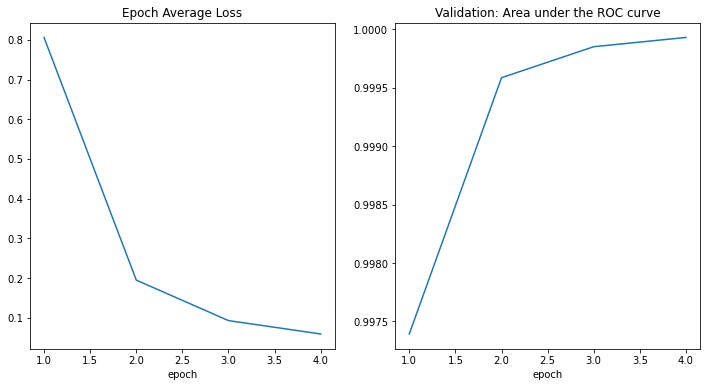

In [14]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset
After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

In [15]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9920    0.9862    0.9891      1012
   BreastMRI     0.9989    0.9916    0.9953       951
         CXR     0.9981    0.9942    0.9961      1039
     ChestCT     0.9898    1.0000    0.9949       968
        Hand     0.9941    0.9951    0.9946      1013
      HeadCT     0.9888    0.9949    0.9919       979

    accuracy                         0.9936      5962
   macro avg     0.9936    0.9937    0.9936      5962
weighted avg     0.9936    0.9936    0.9936      5962

